In [9]:
# Import necessary libraries
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from segmentation_models_pytorch import UnetPlusPlus  # U-Net++from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask


In [11]:
# Define image and mask transforms
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = SegmentationDataset(
    image_dir='/home/abid/Code/U/isic2017/train/images',
    mask_dir='/home/abid/Code/U/isic2017/train/masks',
    transform=image_transform
)

val_dataset = SegmentationDataset(
    image_dir='/home/abid/Code/U/isic2017/val/images',
    mask_dir='/home/abid/Code/U/isic2017/val/masks',
    transform=image_transform
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [12]:
# Initialize U-Net++ model
model = UnetPlusPlus(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model = model.to(device)


In [13]:
# Define loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()  # For binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)


In [14]:
# Define Dice coefficient and Mean IoU functions
def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)  # Apply sigmoid to the output logits
    pred = (pred > 0.5).float()  # Binarize the outputs
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def miou(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    miou = (intersection + smooth) / (union + smooth)
    return miou


In [15]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_dice = 0.0
    running_miou = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and metrics
        running_loss += loss.item()
        running_dice += dice_coefficient(outputs, masks).item()
        running_miou += miou(outputs, masks).item()

    # Average loss and metrics for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_dice = running_dice / len(train_loader)
    epoch_miou = running_miou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Dice: {epoch_dice:.4f}, MIoU: {epoch_miou:.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_dice = 0.0
    val_miou = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            val_dice += dice_coefficient(outputs, masks).item()
            val_miou += miou(outputs, masks).item()

    # Average validation loss and metrics
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_miou /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation MIoU: {val_miou:.4f}")

    # Update learning rate if validation loss plateaus
    scheduler.step(val_loss)


Epoch [1/20], Loss: 0.2623, Dice: 0.8384, MIoU: 0.7323
Validation Loss: 0.2019, Validation Dice: 0.7955, Validation MIoU: 0.6753
Epoch [2/20], Loss: 0.1411, Dice: 0.9029, MIoU: 0.8255
Validation Loss: 0.1656, Validation Dice: 0.8176, Validation MIoU: 0.7030
Epoch [3/20], Loss: 0.1057, Dice: 0.9176, MIoU: 0.8495
Validation Loss: 0.1565, Validation Dice: 0.8031, Validation MIoU: 0.6845
Epoch [4/20], Loss: 0.0955, Dice: 0.9178, MIoU: 0.8502
Validation Loss: 0.1275, Validation Dice: 0.8413, Validation MIoU: 0.7341
Epoch [5/20], Loss: 0.0739, Dice: 0.9335, MIoU: 0.8764
Validation Loss: 0.1378, Validation Dice: 0.8157, Validation MIoU: 0.7065
Epoch [6/20], Loss: 0.0626, Dice: 0.9413, MIoU: 0.8897
Validation Loss: 0.1106, Validation Dice: 0.8477, Validation MIoU: 0.7473
Epoch [7/20], Loss: 0.0554, Dice: 0.9470, MIoU: 0.8997
Validation Loss: 0.1293, Validation Dice: 0.8425, Validation MIoU: 0.7388
Epoch [8/20], Loss: 0.0503, Dice: 0.9511, MIoU: 0.9070
Validation Loss: 0.1359, Validation Dice: 

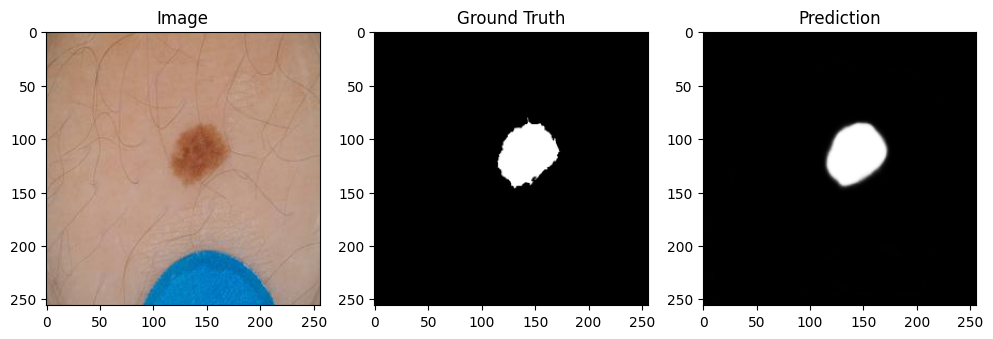

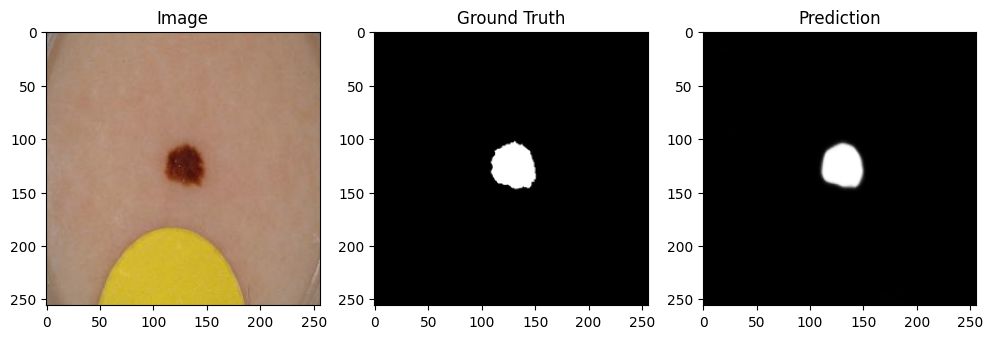

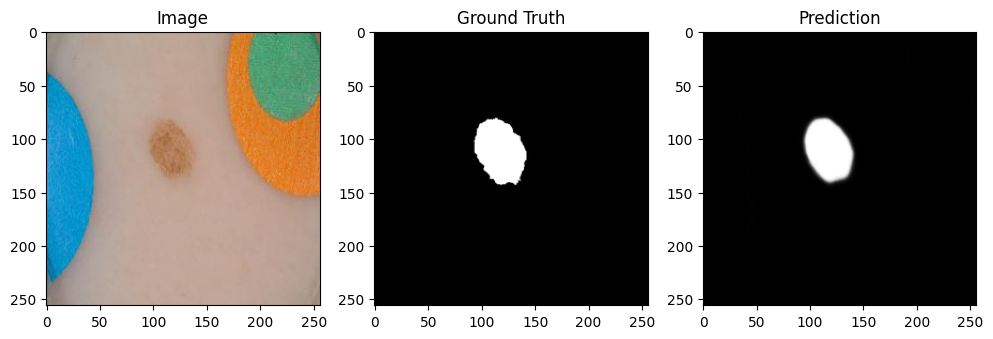

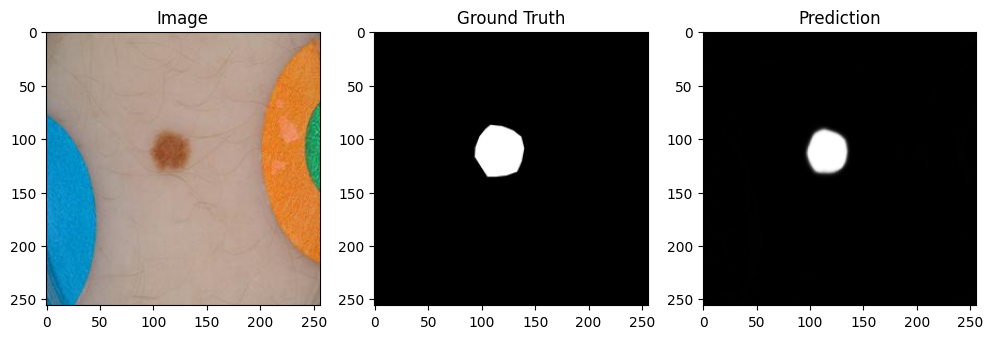

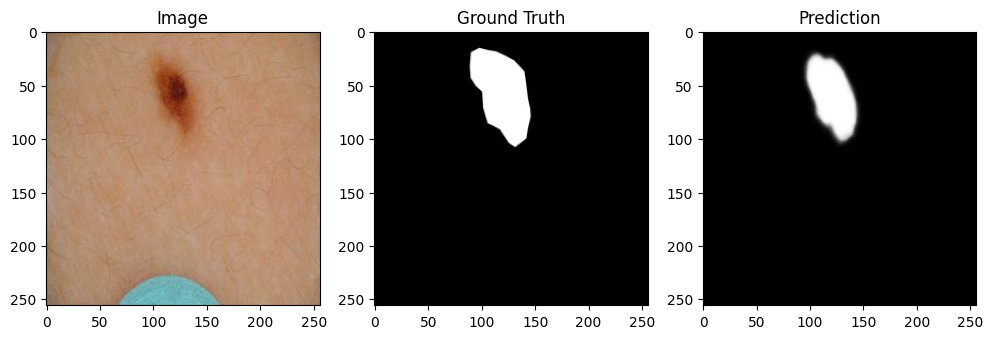

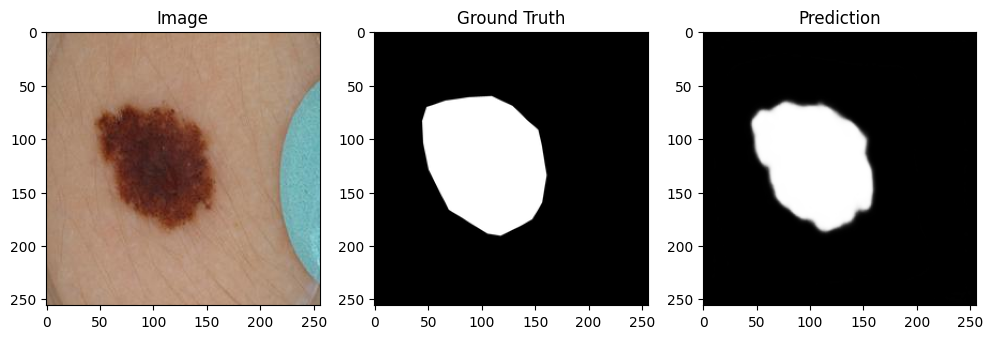

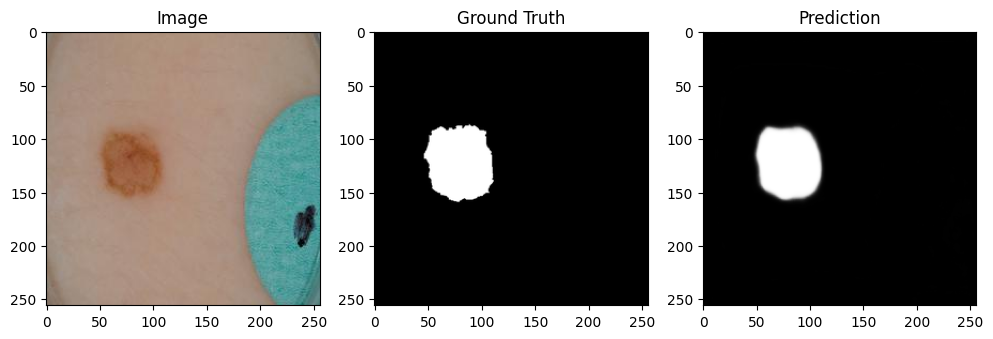

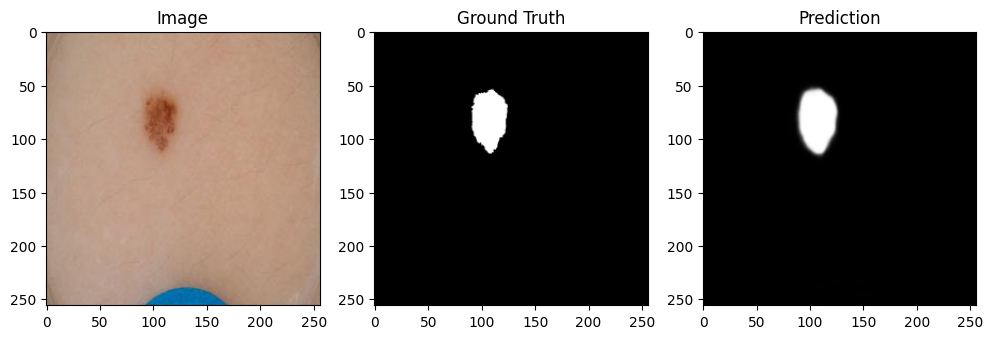

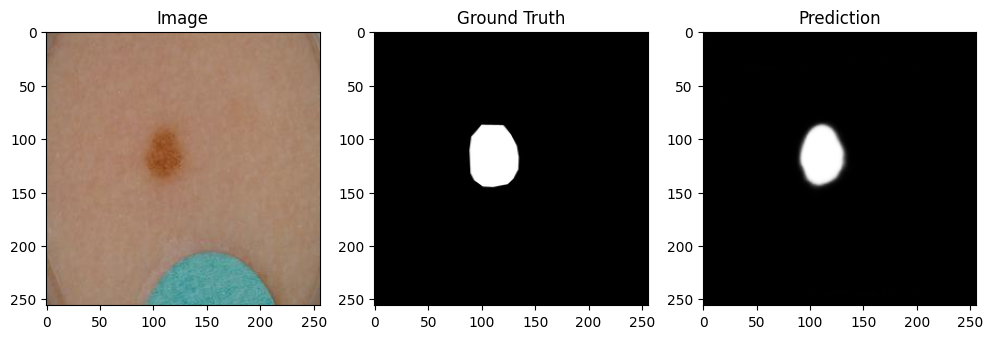

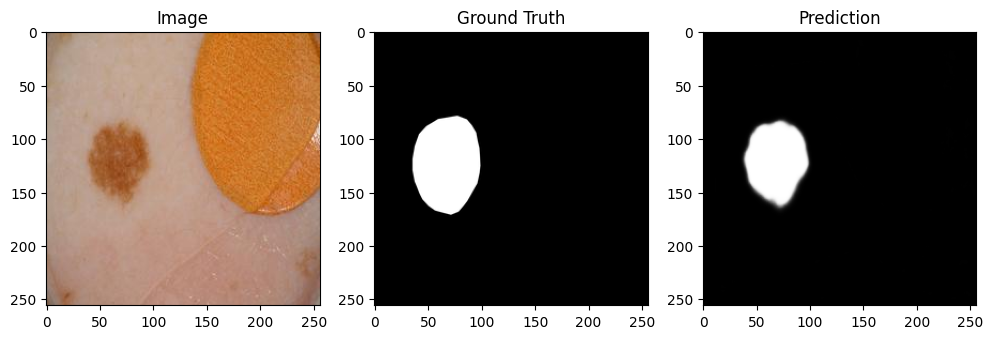

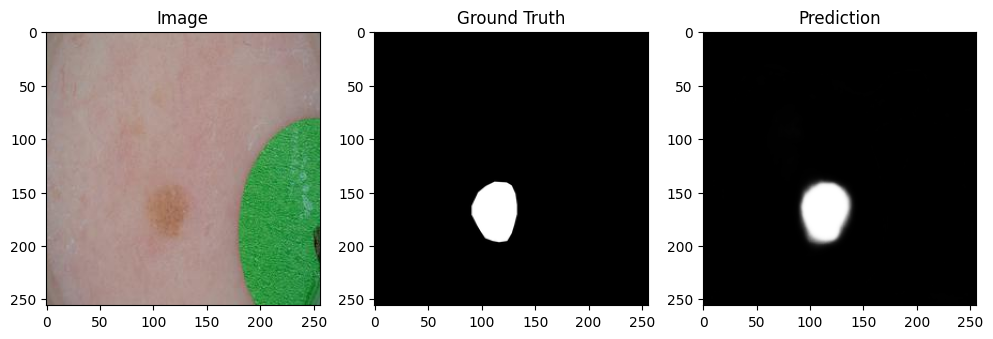

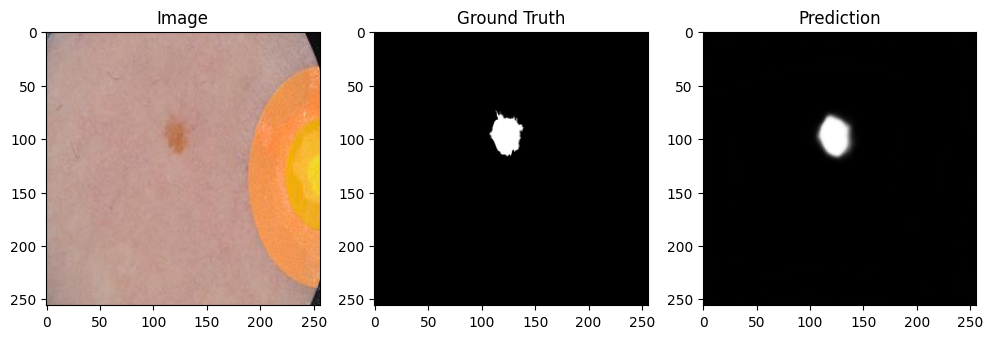

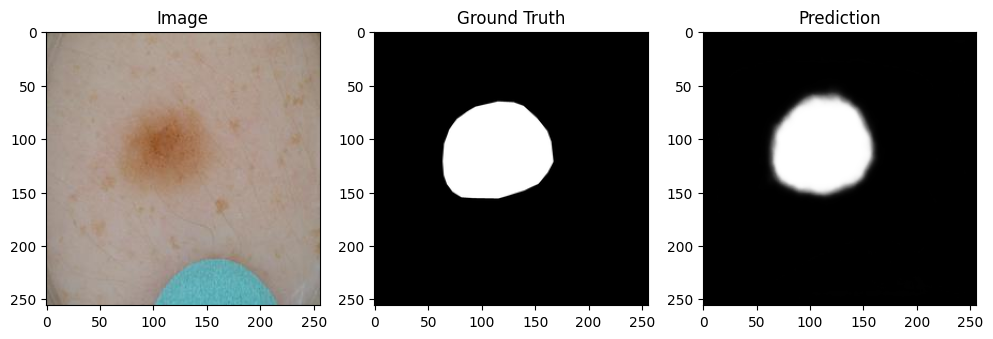

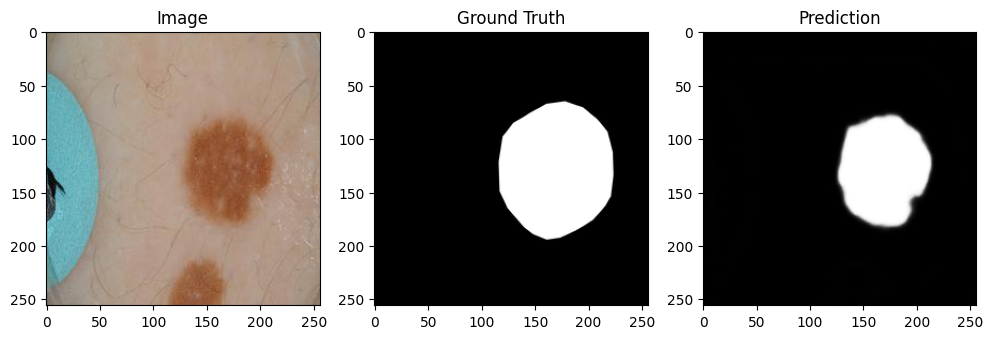

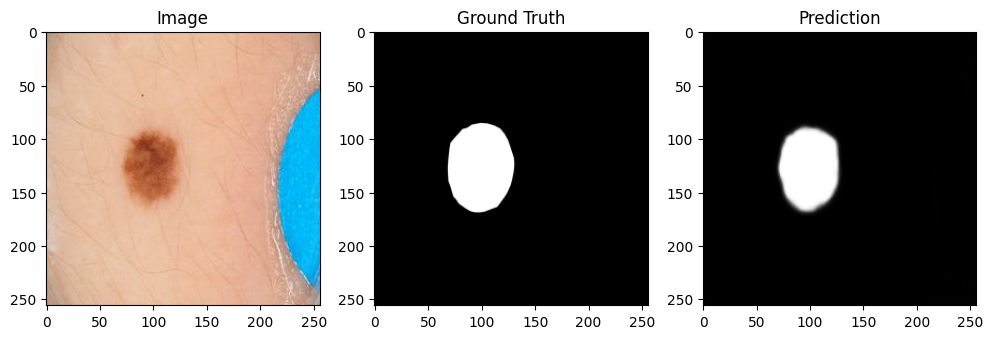

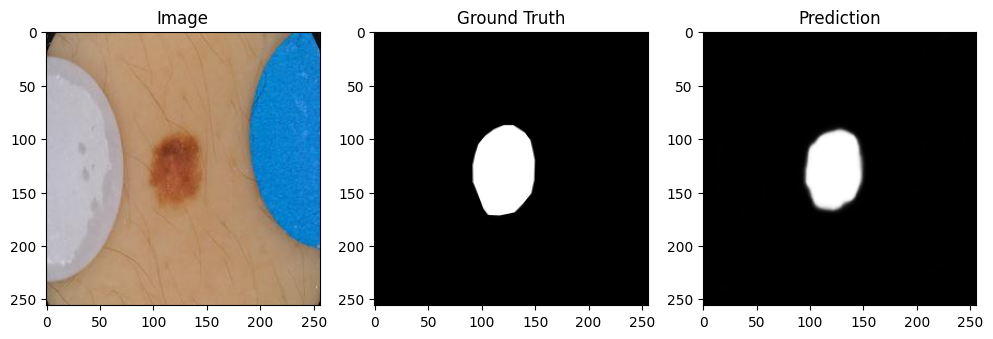

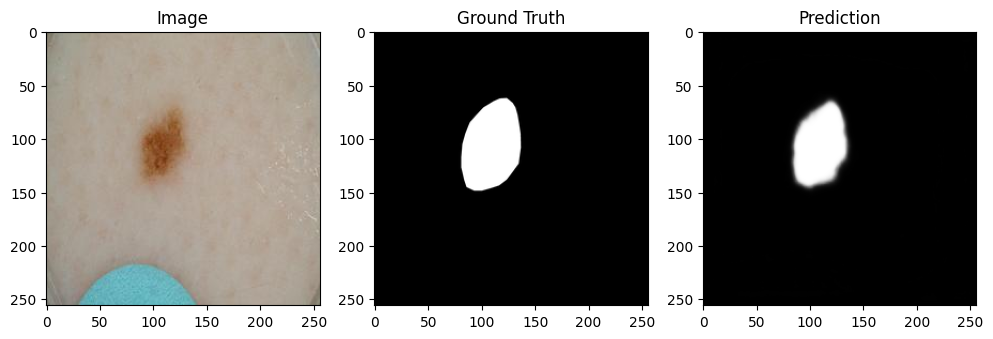

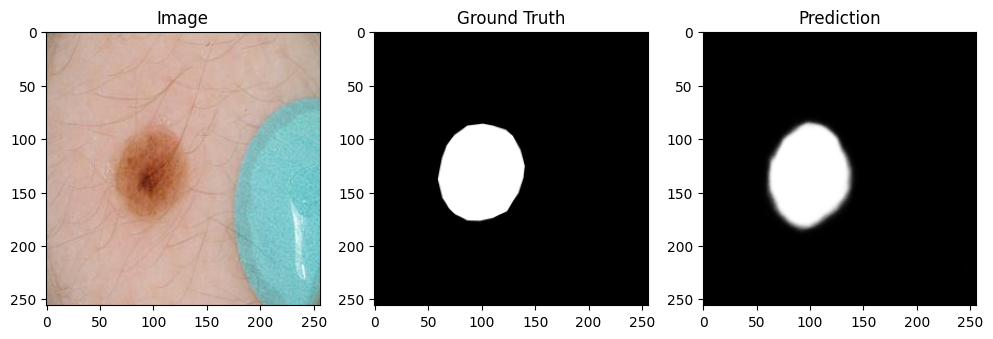

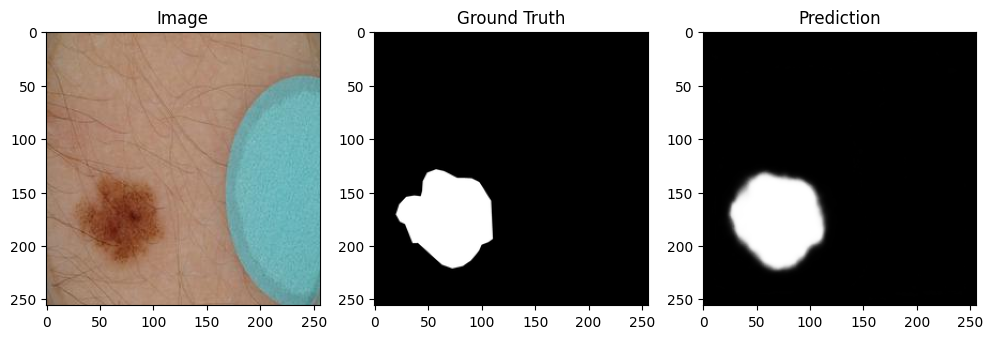

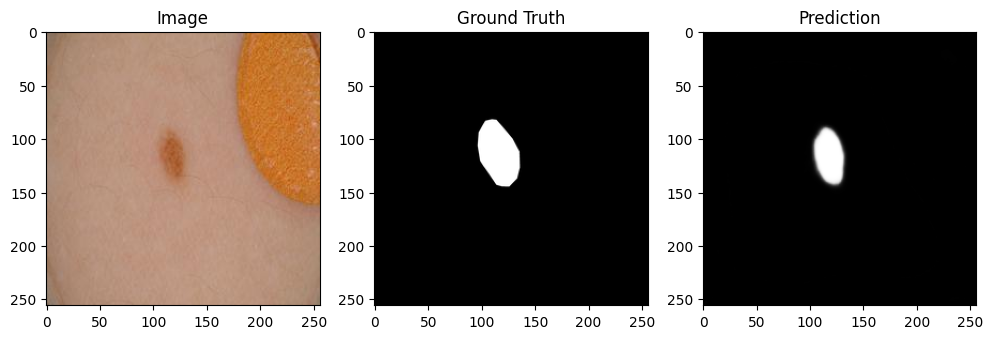

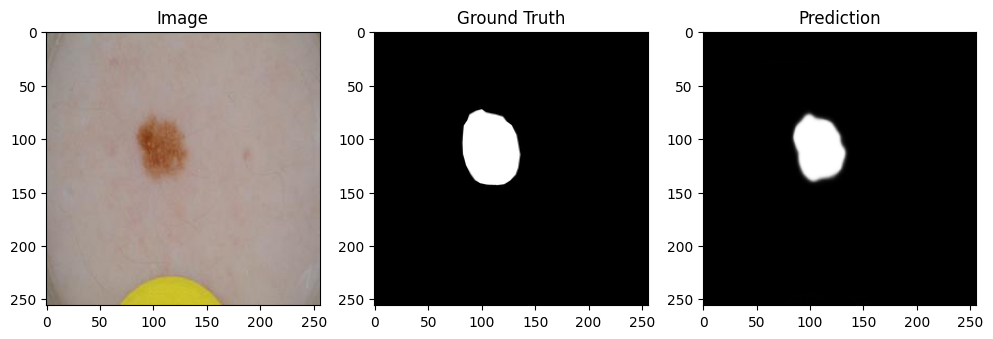

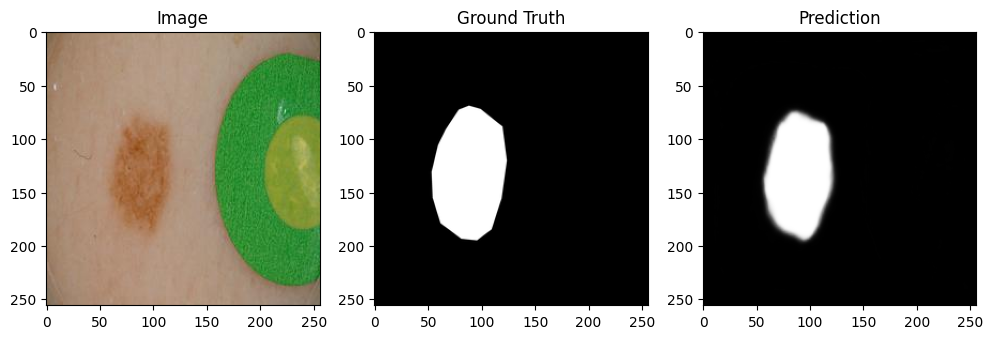

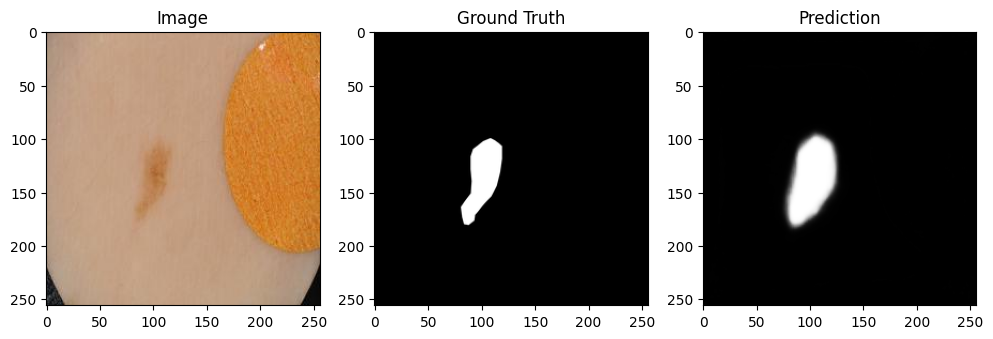

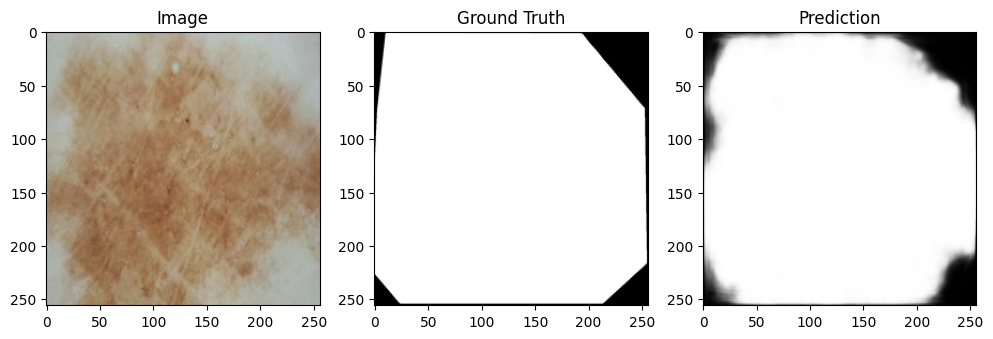

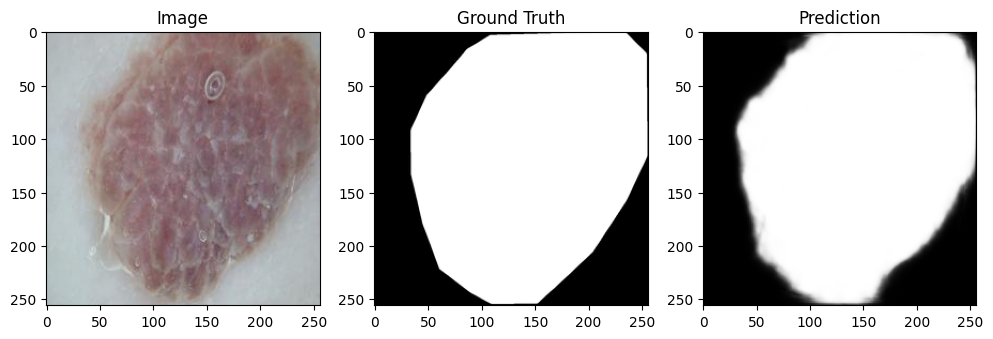

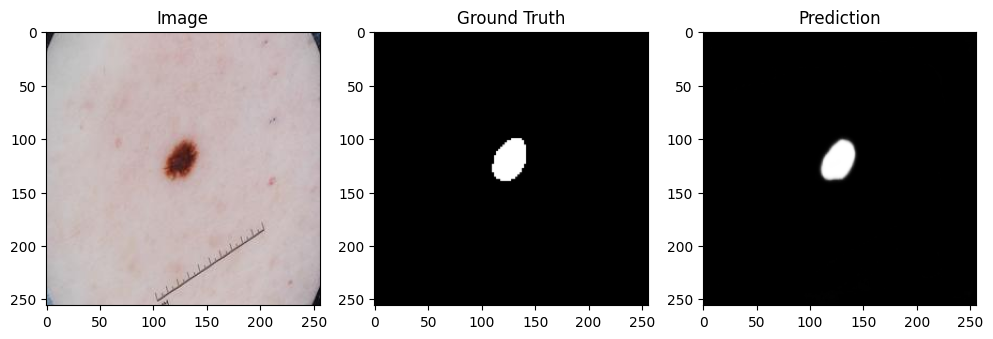

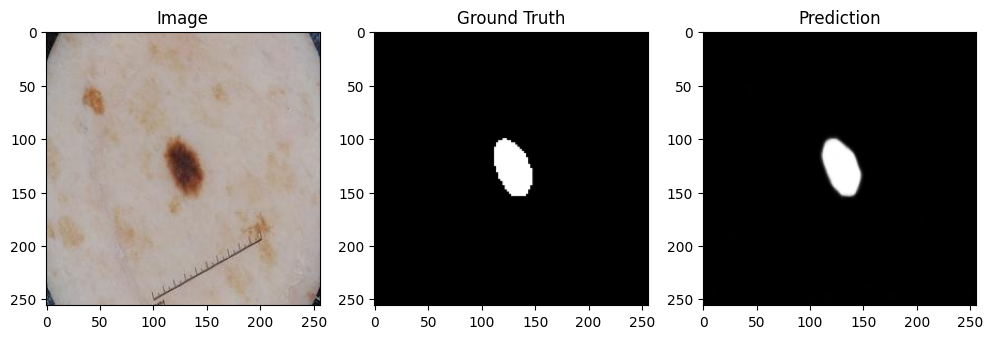

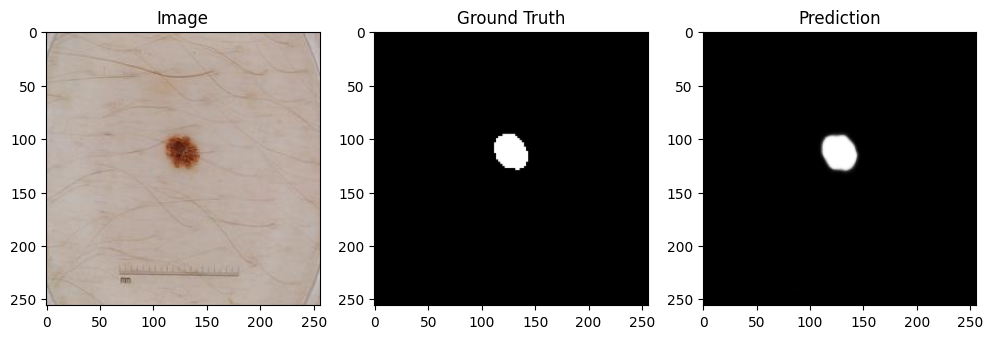

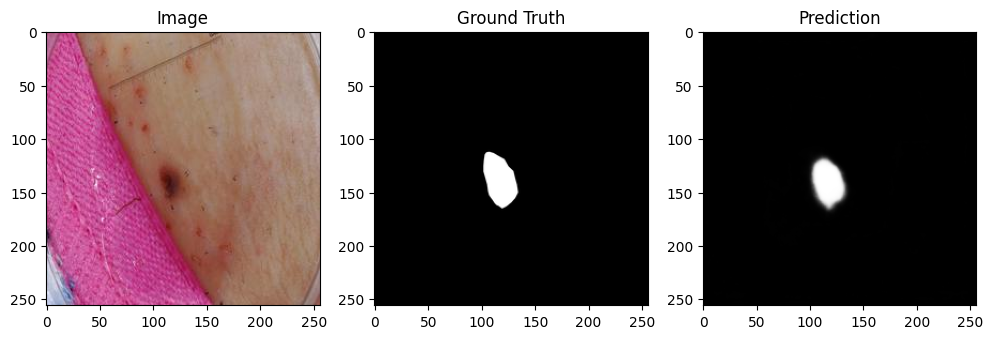

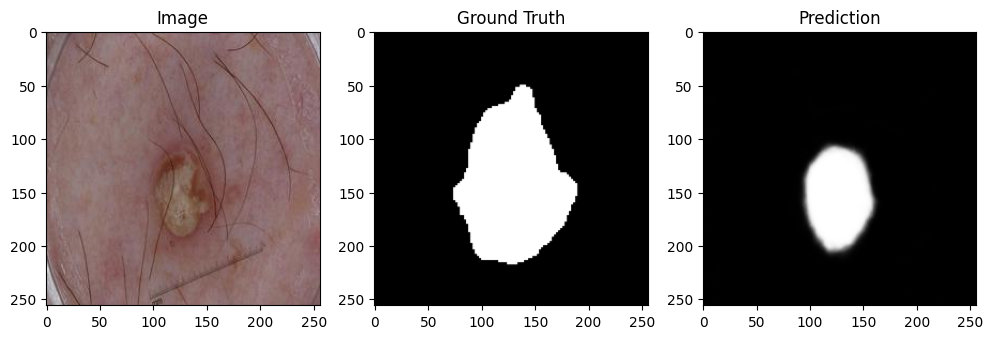

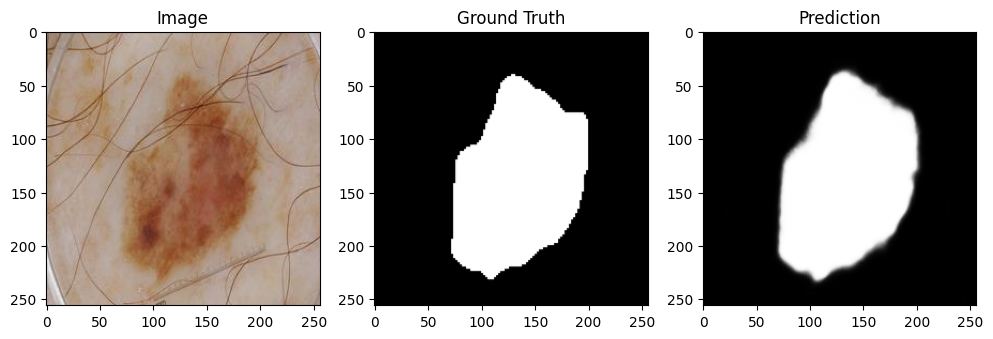

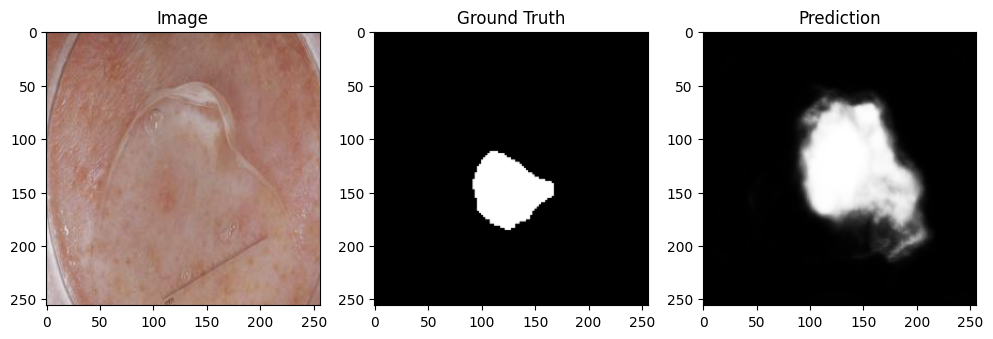

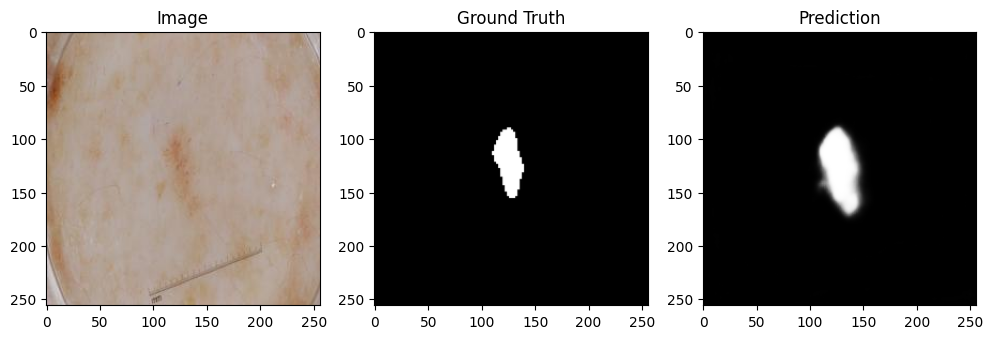

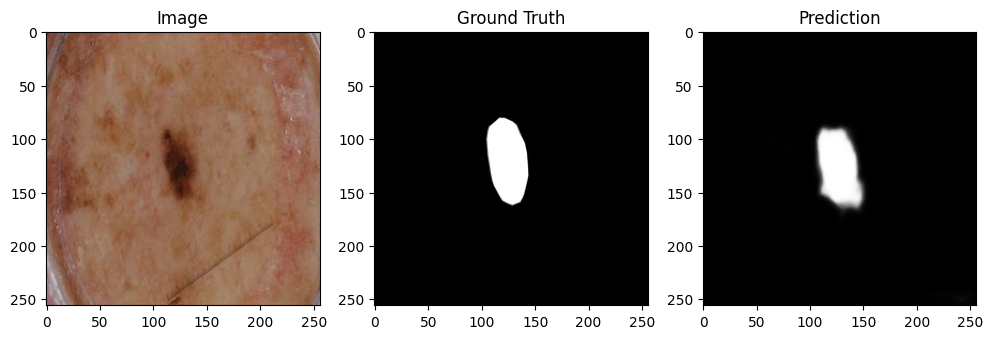

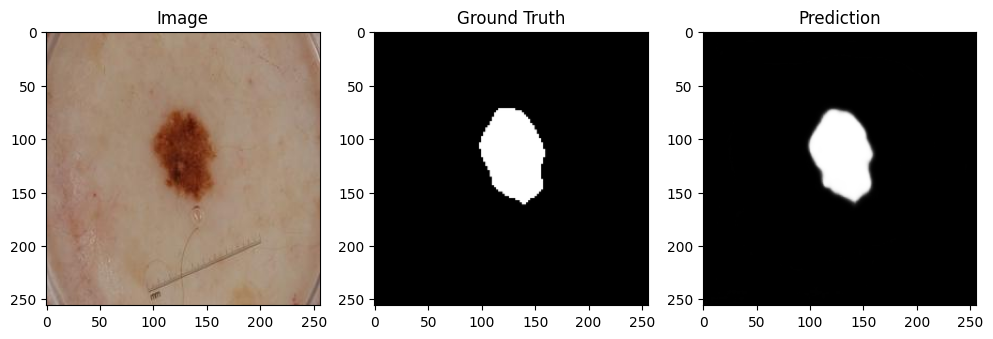

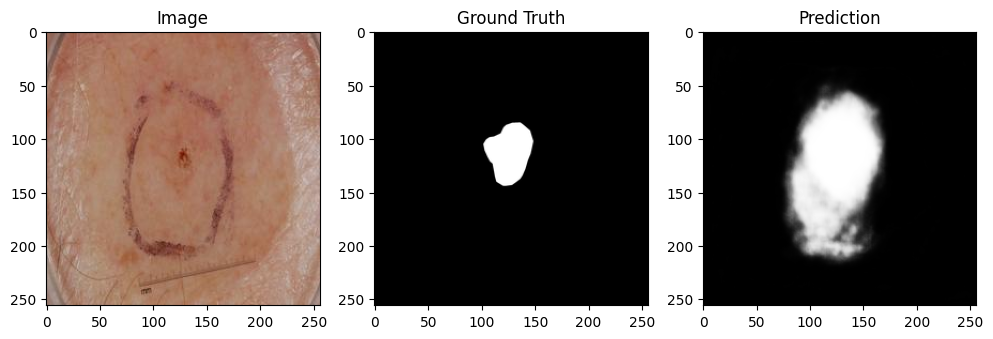

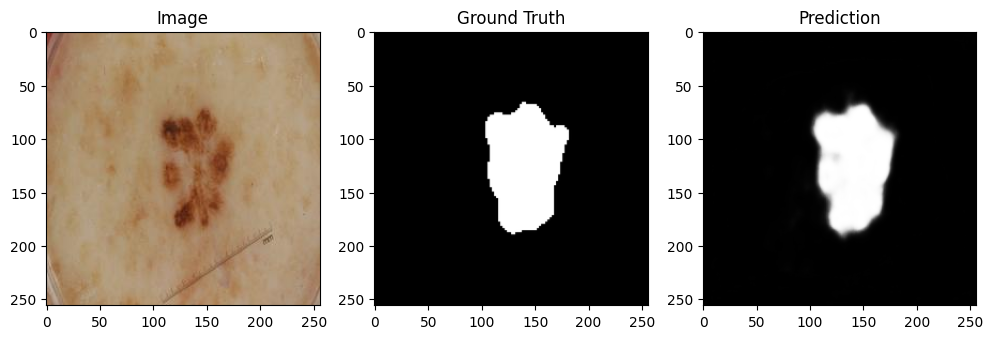

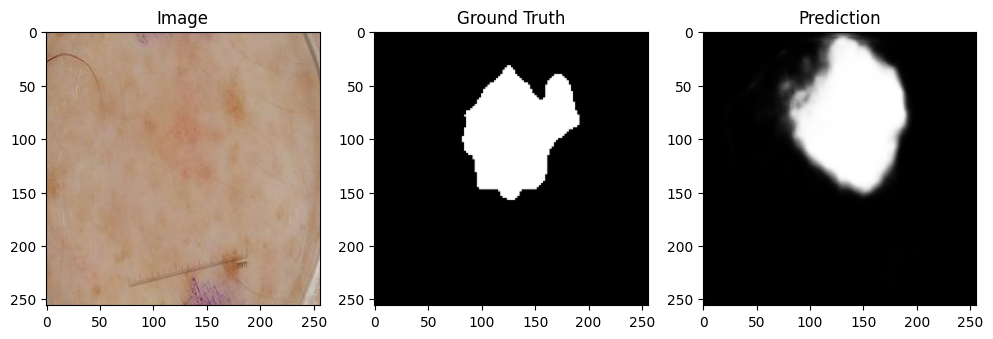

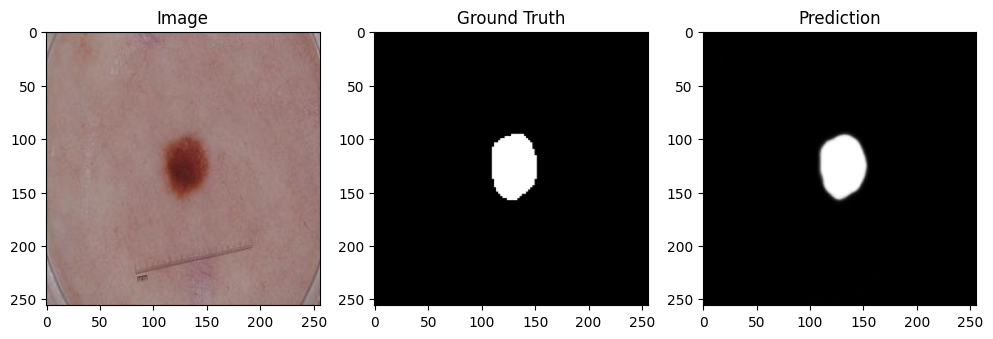

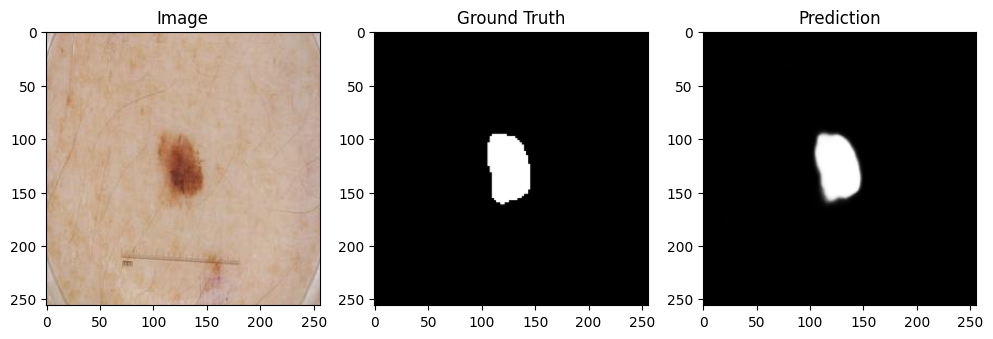

In [16]:
# Function to visualize predictions
def visualize_predictions(model, loader, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            if i >= num_images:
                break
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            
            # Convert to CPU and numpy
            images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
            masks_np = masks.cpu().numpy()
            outputs_np = torch.sigmoid(outputs).cpu().numpy()

            for j in range(images_np.shape[0]):
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 3, 1)
                plt.title('Image')
                plt.imshow(images_np[j])
                plt.subplot(1, 3, 2)
                plt.title('Ground Truth')
                plt.imshow(masks_np[j, 0], cmap='gray')
                plt.subplot(1, 3, 3)
                plt.title('Prediction')
                plt.imshow(outputs_np[j, 0], cmap='gray')
                plt.show()

# Test and visualize
visualize_predictions(model, val_loader)